In [31]:
import numpy as np
import pandas as pd
import datashader as ds

from datashader import transfer_functions as tf
from datashader.utils import lnglat_to_meters as webm

from functools import partial

# Export a datashader plot to an image file (e.g. jpg/png)
from datashader.utils import export_image

# Color Maps
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from matplotlib.cm import hot
from colorcet import fire

# Interactive images
from bokeh.plotting import figure, output_notebook, show
from datashader.bokeh_ext import InteractiveImage

# Overlay our data on a Real Map
from bokeh.tile_providers import STAMEN_TERRAIN

In [3]:
%%time
df = pd.read_csv('data/accidents_2005_to_2007.csv', usecols=['Longitude', 'Latitude', 'Road_Type'])

CPU times: user 1.33 s, sys: 121 ms, total: 1.46 s
Wall time: 1.48 s


In [4]:
df.tail()

,Longitude,Latitude,Road_Type
570006,-3.210294,54.985289,Single carriageway
570007,-3.193693,54.984105,Single carriageway
570008,-2.992068,55.166369,Single carriageway
570009,-3.058338,54.995154,Single carriageway
570010,-3.348857,55.104618,Single carriageway


In [5]:
df.shape

(570011, 3)

In [8]:
df.dtypes

Longitude    float64
Latitude     float64
Road_Type     object
dtype: object

In [10]:
df['Road_Type'] = df['Road_Type'].astype('category')
df.dtypes

Longitude     float64
Latitude      float64
Road_Type    category
dtype: object

In [12]:
df.groupby('Road_Type').size()

Road_Type
Dual carriageway       87274
One way street         12434
Roundabout             36637
Single carriageway    423414
Slip road               5936
Unknown                 4316
dtype: int64

## Obtain Web Mercator X-Y Values

In [15]:
x, y = [c for c in list(webm(df.loc[:, 'Longitude'], df.loc[:, 'Latitude']))]

In [19]:
df = df.assign(webm_x=x).copy()
df = df.assign(webm_y=y).copy()

df.tail()

,Longitude,Latitude,Road_Type,webm_x,webm_y
570006,-3.210294,54.985289,Single carriageway,-357368.293377,7.359012e+06
570007,-3.193693,54.984105,Single carriageway,-355520.278510,7.358782e+06
570008,-2.992068,55.166369,Single carriageway,-333075.486179,7.394222e+06
570009,-3.058338,54.995154,Single carriageway,-340452.628834,7.360926e+06
570010,-3.348857,55.104618,Single carriageway,-372793.055979,7.382197e+06


In [20]:
bboxes = {
  "gb": ((-15.381, 7.251), (48.749, 61.502)),
  "gb_mainland": ( (-12.129, 5.120), (49.710, 58.745)),
  "gb_long": ((-8.745, 2.241), (48.749, 61.502)),
  "gb_wide": ((-21.709, 15.293), (48.749, 61.502)),
  "london": ((-0.643, 0.434), (51.200, 51.761)),
  "london_2": ((-0.1696, 0.0130), (51.4546, 51.5519)),
  "london_3": ((-0.1330, -0.0235), (51.4741, 51.5322)),  
  "manchester": ((-3.049, -1.505), (52.975, 53.865))
}

In [21]:
bboxes["gb"]

((-15.381, 7.251), (48.749, 61.502))

In [24]:
webm(*bboxes["gb"])

(array([-1712205.08789134,   807177.62774203]),
 array([6232378.76591682, 8742012.04392761]))

In [25]:
PLOT_WIDTH= 750

def get_plot_size(x_range, y_range, plot_width=PLOT_WIDTH):
    x_range_dist = x_range[1] - x_range[0]
    y_range_dist = y_range[1] - y_range[0]
    plot_height = int(y_range_dist * plot_width /x_range_dist)
    return (plot_width, plot_height)

In [26]:
print("Britian Bounding Box")
print("  - in lng/lat ranges: {}".format(bboxes["gb"]))
print("  - in Web Mercator X-Y ranges: {}".format(webm(*bboxes["gb"])))
print("  - in Plot width-height: {}".format(get_plot_size(*webm(*bboxes["gb"]))))

Britian Bounding Box
  - in lng/lat ranges: ((-15.381, 7.251), (48.749, 61.502))
  - in Web Mercator X-Y ranges: (array([-1712205.08789134,   807177.62774203]), array([6232378.76591682, 8742012.04392761]))
  - in Plot width-height: (750, 747)


In [27]:
def get_plot_params(bbox, plot_width=PLOT_WIDTH):
    x_range, y_range = webm(*bbox)
    plot_width, plot_height = get_plot_size(x_range, y_range, plot_width=plot_width)
    return x_range, y_range, plot_width, plot_height

In [28]:
get_plot_params(bboxes["gb"])

(array([-1712205.08789134,   807177.62774203]),
 array([6232378.76591682, 8742012.04392761]),
 750,
 747)

In [29]:
background = "black"

In [32]:
export = partial(export_image, background=background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [33]:
%%time
x_range, y_range, plot_width, plot_height = get_plot_params(bboxes["gb"])
cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points(df, 'webm_x', 'webm_y')

CPU times: user 408 ms, sys: 12.8 ms, total: 421 ms
Wall time: 435 ms


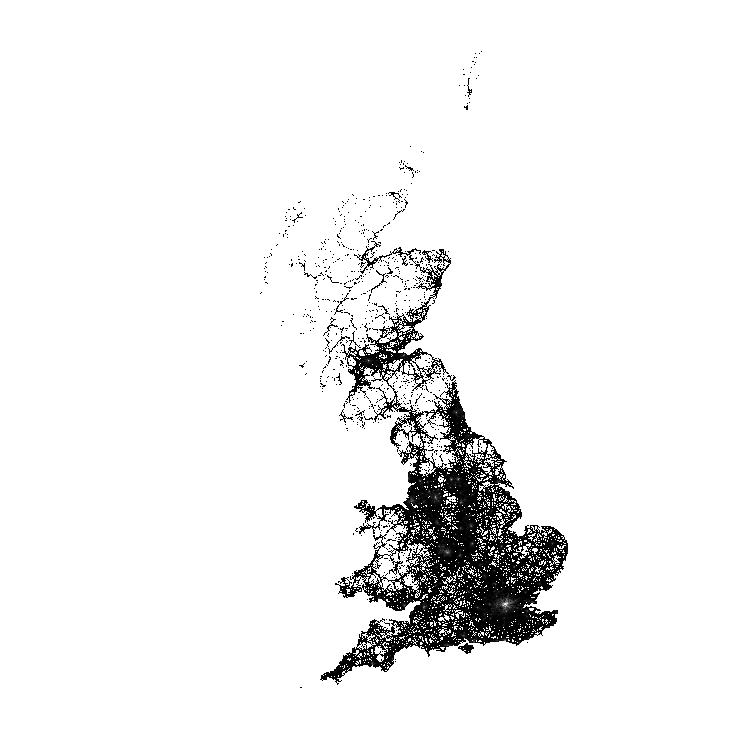

In [34]:
tf.shade(agg, cmap = cm(Greys9), how='linear')

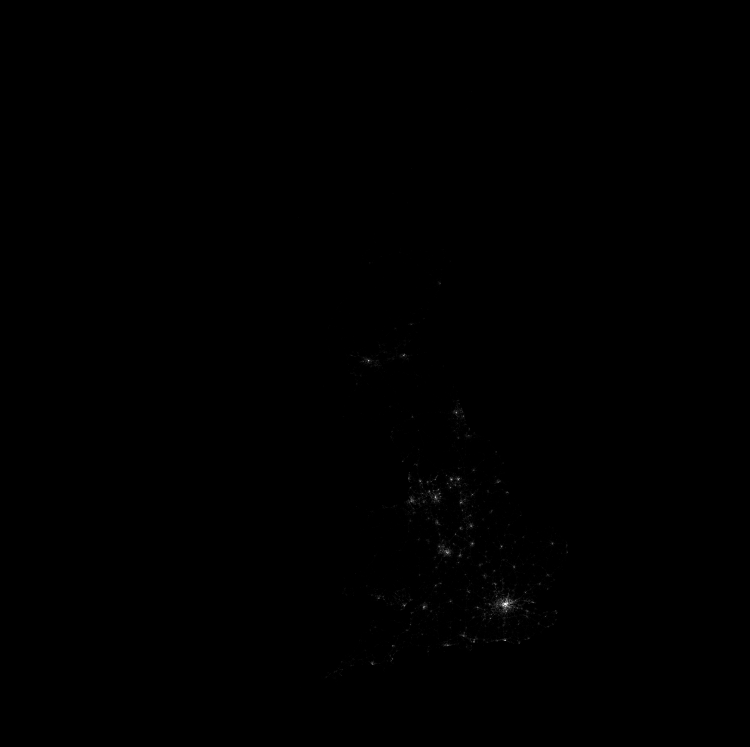

In [35]:
export(tf.shade(agg, cmap = cm(Greys9), how='linear'),"gb_gray_linear")

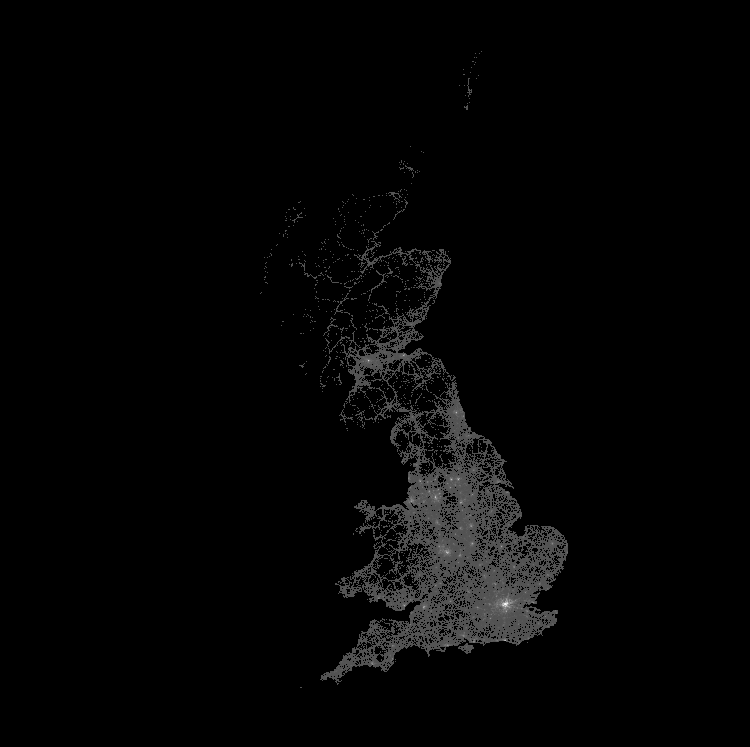

In [36]:
export(tf.shade(agg, cmap = cm(Greys9,0.25), how='linear'),"gb_gray_linear_0.25")

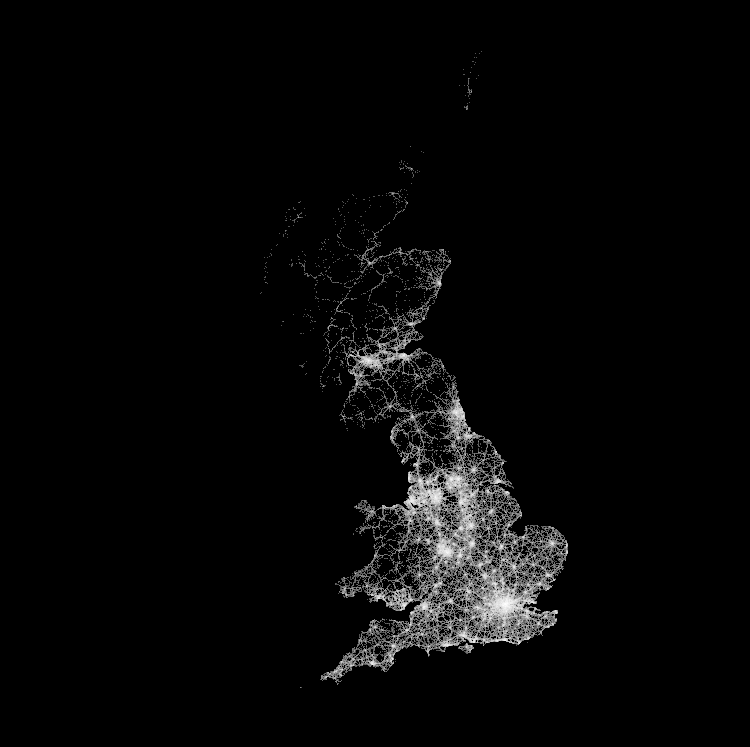

In [37]:
export(tf.shade(agg, cmap = cm(Greys9,0.25), how='log'),"gb_gray_log_0.25")

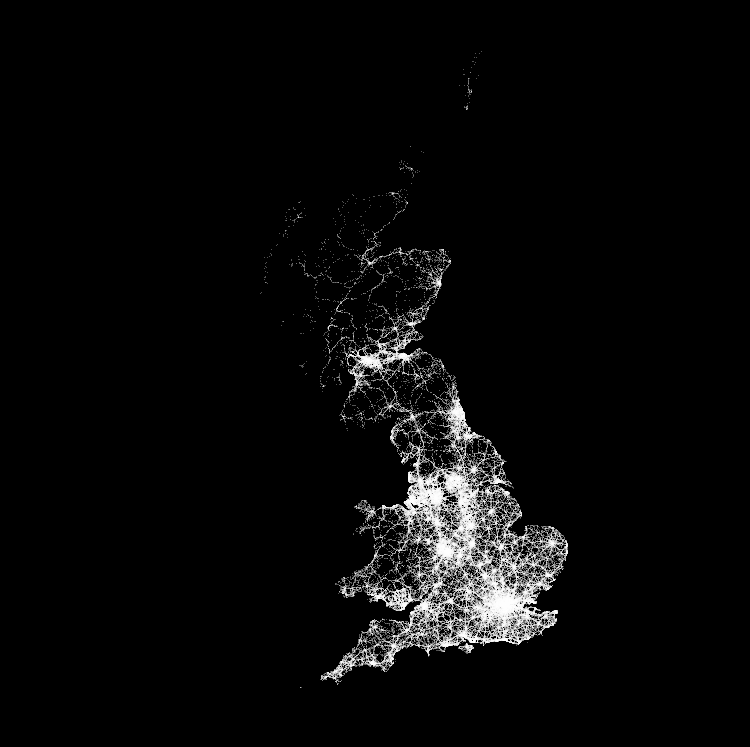

In [38]:
export(tf.shade(agg, cmap = cm(Greys9,0.25), how='eq_hist'),"gb_gray_eq_hist")

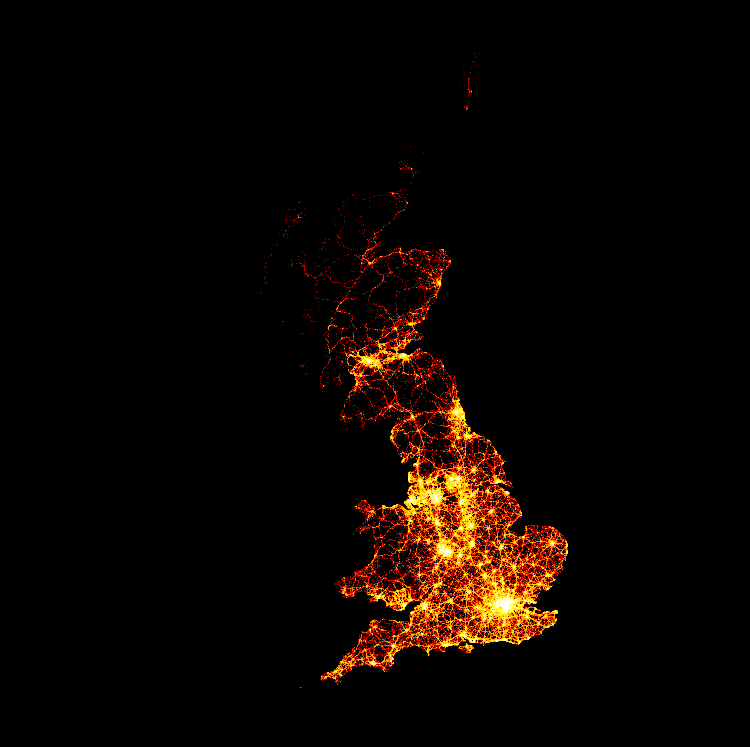

In [39]:
export(tf.shade(agg, cmap=cm(fire, 0.25), how='eq_hist'),"gb_fire_eq_hist_0.25")

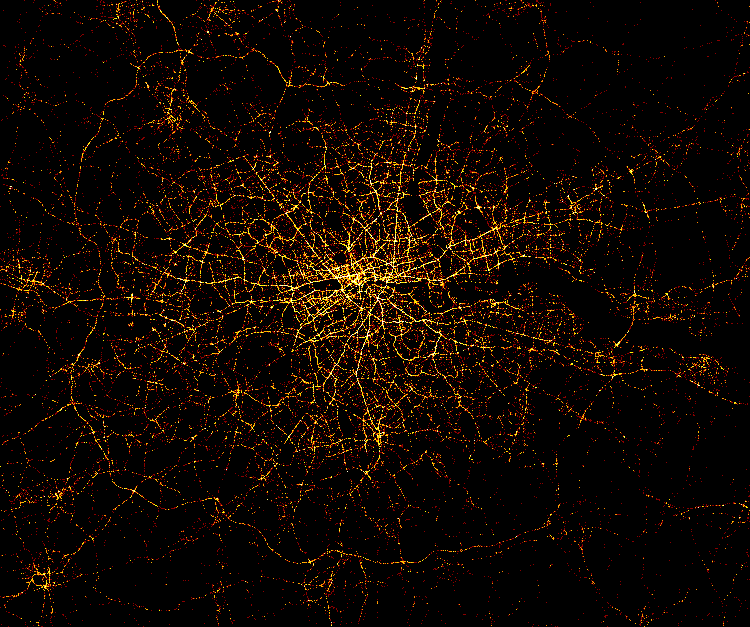

In [40]:
x_range, y_range, plot_width, plot_height = get_plot_params(bboxes["london"])
cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points(df, 'webm_x', 'webm_y')
export(tf.shade(agg, cmap=cm(Hot, 0.25), how='eq_hist'),"london_Hot_eq_hist_0.25")

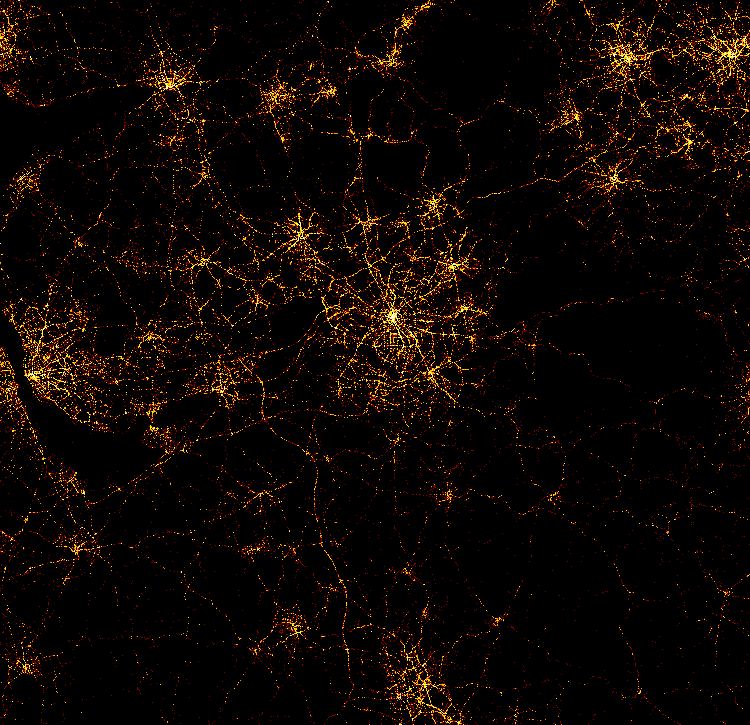

In [41]:
x_range, y_range, plot_width, plot_height = get_plot_params(bboxes["manchester"])
cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points(df, 'webm_x', 'webm_y')
export(tf.shade(agg, cmap=cm(Hot, 0.25), how='eq_hist'),"manchester_Hot_eq_hist_0.25")